## Working code of dynamic quenching 2014 paper
### U_0 = 1km/s, R_k = 0.3

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import astropy.units as u
from prettytable import PrettyTable

In [2]:
T=27
Nt=int(2000*T)
Nz=51


In [3]:
radius_dim=4*u.kpc
r_d_dim = 10*u.kpc
h_d_dim=0.35*u.kpc
eta_dim = (10e25*(u.cm**2/u.s)).to(u.kpc**2/u.Gyr)
h_dim=h_d_dim*np.sqrt(1+((radius_dim/r_d_dim)**2))
td_dim=(h_dim**2/eta_dim.to(u.kpc**2/u.Gyr))
B_0_dim=8.2e-6*u.G
omega_0_dim=127*u.km/(u.s*u.kpc)
r_omega_dim=2*u.kpc
l_dim=0.1*u.kpc
omega_dim = omega_0_dim*(1+((radius_dim/r_omega_dim)**2))**(-1/2)
alpha_0_dim=(l_dim**2)*omega_dim/h_dim
G_dim=-omega_dim
G_dim = -45.6*u.km/(u.s*u.kpc)

U_0_dim=1*u.km/u.s
#km kpc/s
k_dim=0.1*(u.km*u.kpc/u.s)


R_dim=20*u.kpc
z_i_dim = -h_dim
z_f_dim= h_dim


In [4]:
z_i=(z_i_dim/h_dim).value
z_f=(z_f_dim/h_dim).value
r = np.linspace(z_i, z_f, Nz)

eta=(eta_dim/eta_dim).value
omega_0=(omega_0_dim.to(1/u.Gyr)*(h_dim/eta_dim)).value
r_omega=(r_omega_dim/z_f_dim).value
h_d=(h_d_dim/h_dim).value
r_d=(r_d_dim/h_dim).value
l=(l_dim/h_dim).value

U_0=((U_0_dim.to(u.kpc/u.Gyr))*eta_dim/h_dim**2).value
#km kpc/s to dimensionless
k=((k_dim.to(u.kpc**2/u.Gyr))/eta_dim).value
B_0=(B_0_dim/B_0_dim).value
R=(R_dim/h_dim).value
radius=(radius_dim/h_dim).value
h=(h_dim/h_dim).value
td=(td_dim*eta_dim/h_dim**2).value
B_eq=B_0*np.exp(-(radius/R))-r**2/(2*h**2)
#alpha=alpha_m+alpha_tilda
U_z=r/h
alpha_0=(alpha_0_dim*h_dim/eta_dim).value
#km/kpc s to dimensionless
G=((G_dim.to(1/u.Gyr))*h_dim**2/eta_dim).value

alpha_tilda=np.sin((np.pi*(r)))


R_alpha=alpha_0 
R_omega=G
R_u=U_0
R_k=k



In [5]:
table = PrettyTable()
table.field_names = ["Parameter", "Value in Dimensional Units", "Value in Dimensionless Units"]
table.add_row(["eta", eta_dim, eta])
table.add_row(["radius", radius_dim, radius])
table.add_row(["r_d", radius_dim, r_d])
table.add_row(["h_d", h_d_dim, h_d])
table.add_row(["h", h_dim, h])
table.add_row(["td", td_dim, td])
table.add_row(["B_eq", f'B0 = {B_0_dim}', B_eq])
table.add_row(["alpha_0", alpha_0_dim, alpha_0])
table.add_row(["G", G_dim, G])
table.add_row(["omega_0", omega_0_dim, omega_0])
table.add_row(["r_omega", r_omega_dim, r_omega])
table.add_row(["l", l_dim, l])
table.add_row(["B_0", B_0_dim, B_0])
table.add_row(["R", R_dim, R])
table.add_row(["U_0", U_0_dim, U_0])
table.add_row(["k", k_dim, k])
table.add_row(["z_i", z_i_dim, z_i])
table.add_row(["z_f", z_f_dim, z_f])
table.add_row(["R_alpha", alpha_0_dim, R_alpha])
table.add_row(["R_omega", omega_0_dim, R_omega])
table.add_row(["R_u", U_0, R_u])
table.add_row(["R_k", k, R_k])
# table.add_row(["R_B", B_0_dim, B_eq[0]])


print(table)


+-----------+-------------------------------+--------------------------------------------------------------------+
| Parameter |   Value in Dimensional Units  |                    Value in Dimensionless Units                    |
+-----------+-------------------------------+--------------------------------------------------------------------+
|    eta    | 0.3314384403542896 kpc2 / Gyr |                                1.0                                 |
|   radius  |            4.0 kpc            |                         10.611162181545819                         |
|    r_d    |            4.0 kpc            |                         26.52790545386455                          |
|    h_d    |            0.35 kpc           |                         0.9284766908852592                         |
|     h     |    0.37696153649941533 kpc    |                                1.0                                 |
|     td    |     0.4287372335209606 Gyr    |                                1.0

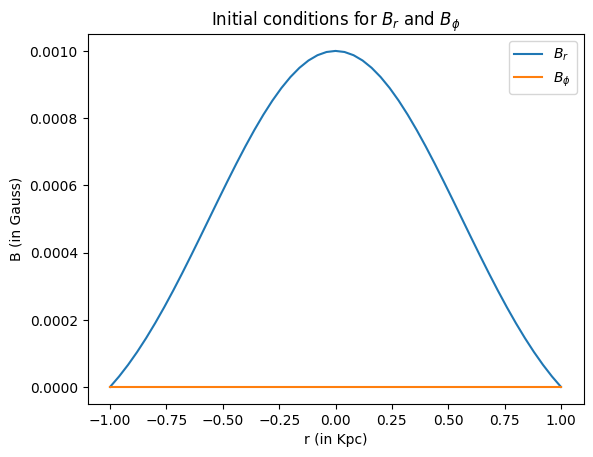

In [6]:
#initial conditions

r = np.linspace(z_i, z_f, Nz)

dr = r[1] - r[0]               


def B_phi0(r):
    return np.zeros_like(r)

def B_r0(r):
    return 10e-4*B_0*(1-r**2)*np.exp(-r**2)
def alpha_m0(r):
    return np.zeros_like(r)
B_r = B_r0(r)
B_phi=B_phi0(r)
alpha_m=alpha_m0(r)
dt = T/Nt

plt.plot(r,B_r)
plt.xlabel('r (in Kpc)')
plt.ylabel('B (in Gauss)')
plt.plot(r,B_phi)
plt.legend(['$B_r$',r'$B_{\phi}$'])
plt.title(r'Initial conditions for $B_r$ and $B_{\phi}$')
plt.savefig('Initizeros_like(r)al_conditions_save.png')
plt.show()

In [7]:
def spatial_derivative(B_r, B_phi,dr,ghost_zone_type,fd_order):

#GHOST ZONE HANDLING
    B_r=np.copy(B_r)
    B_phi=np.copy(B_phi)

    cell_needed = int(fd_order/2)
    if ghost_zone_type == 'symmetric':
        B_r = np.pad(B_r,(cell_needed,cell_needed),'reflect')
        B_phi = np.pad(B_phi,(cell_needed,cell_needed),'reflect')
    elif ghost_zone_type == 'smooth':
        B_r = np.pad(B_r,(cell_needed,cell_needed),'reflect',reflect_type='odd')
        B_phi = np.pad(B_phi,(cell_needed,cell_needed),'reflect',reflect_type='odd')
    elif ghost_zone_type == 'anti-symmetric':
        B_r = np.pad(B_r,(cell_needed,cell_needed),'reflect')
        B_phi = np.pad(B_phi,(cell_needed,cell_needed),'reflect') 
        for i in range(1,cell_needed+1):
            B_r[cell_needed-i] = -B_r[cell_needed-i]
            B_r[-cell_needed-1+i]=-B_r[-cell_needed-1+i]
            B_phi[cell_needed-i] = -B_phi[cell_needed-i]
            B_phi[-cell_needed-1+i]=-B_phi[-cell_needed-1+i]
      
    elif ghost_zone_type == 'relative anti-symmetric':
        B_r = np.pad(B_r,(cell_needed,cell_needed),'constant')
        B_phi = np.pad(B_phi,(cell_needed,cell_needed),'constant')
        for i in range (1,cell_needed+1):
            B_r[cell_needed-i] = 2*B_r[cell_needed] - B_r[cell_needed+i]
            B_r[-cell_needed-1+i]=2*B_r[-cell_needed-1] - B_r[-cell_needed-1-i]
            B_phi[cell_needed-i] = 2*B_phi[cell_needed] - B_phi[cell_needed+i]
            B_phi[-cell_needed-1+i]=2*B_phi[-cell_needed-1] - B_phi[-cell_needed-1-i]
    else:
        B_r = np.pad(B_r,(cell_needed,cell_needed),'constant')
        B_phi = np.pad(B_phi,(cell_needed,cell_needed),'constant')

#FINITE DIFFERENCE
    
    if fd_order == 2:
        dB_r_dr = (-B_r[:-2] + B_r[1:])/(2*dr)
        dB_phi_dr = (-B_phi[:-2] + B_phi[1:])/(2*dr)
        d_sq_Br_dr = (B_r[:-2]-2*B_r[1:-1]+B_r[1:])/(dr**2)
        d_sq_Bphi_dr = (B_phi[:-2]-2*B_phi[1:-1]+B_phi[1:])/(dr**2)

    elif fd_order == 4:
        dB_r_dr = (B_r[:-4] - (8*B_r[1:-3]) + (8*B_r[3:-1]) - B_r[4:]) / (12*dr)
        dB_phi_dr = (B_phi[:-4] - (8*B_phi[1:-3]) + (8*B_phi[3:-1]) - B_phi[4:]) / (12*dr)
        d_sq_Br_dr = ((-B_r[:-4]) + (16*B_r[1:-3]) + (-30*B_r[2:-2]) + (16*B_r[3:-1]) (-B_r[4:])) / (12*(dr**2))
        d_sq_Bphi_dr = ((-B_phi[:-4]) + (16*B_phi[1:-3]) + (-30*B_phi[2:-2]) + (16*B_phi[3:-1]) (-B_phi[4:])) / (12*(dr**2))

    elif fd_order == 6:
        dB_r_dr = ((-B_r[:-6]) + (9 * B_r[1:-5]) - (45*B_r[2:-4]) + (45*B_r[4:-2]) - (9*B_r[5:-1]) + B_r[6:]) / (60*dr)
        dB_phi_dr = ((-B_phi[:-6]) + (9 * B_phi[1:-5]) - (45*B_phi[2:-4]) + (45*B_phi[4:-2]) - (9*B_phi[5:-1]) + B_phi[6:]) / (60*dr)
        d_sq_Br_dr = ((2*B_r[:-6]) - (27*B_r[1:-5]) + (270*B_r[2:-4]) - (490*B_r[3:-3]) + (270*B_r[4:-2]) - (27*B_r[5:-1]) + (2*B_r[6:])) / (180*(dr**2))
        d_sq_Bphi_dr = ((2*B_phi[:-6]) - (27*B_phi[1:-5]) + (270*B_phi[2:-4]) - (490*B_phi[3:-3]) + (270*B_phi[4:-2]) - (27*B_phi[5:-1]) + (2*B_phi[6:])) / (180*(dr**2))

    elif fd_order == 8:
        dB_r_dr = ((3*B_r[:-8]) - (32*B_r[1:-7]) + (168*B_r[2:-6]) - (672*B_r[3:-5]) + (672*B_r[5:-3]) - (168*B_r[6:-2]) + (32*B_r[7:-1]) - (3*B_r[8:])) / (840*dr)
        dB_phi_dr = ((3*B_phi[:-8]) - (32*B_phi[1:-7]) + (168*B_phi[2:-6]) - (672*B_phi[3:-5]) + (672*B_phi[5:-3]) - (168*B_phi[6:-2]) + (32*B_phi[7:-1]) - (3*B_phi[8:])) / (840*dr)
        d_sq_Br_dr = ((-9*B_r[:-8]) + (128*B_r[1:-7]) - (1008*B_r[2:-6]) + (8064*B_r[3:-5]) - (14350*B_r[4:-4]) + (8064*B_r[5:-3]) - (1008*B_r[6:-2]) + (128*B_r[7:-1]) - (9*B_r[8:])) / (5040*(dr**2))
        d_sq_Bphi_dr = ((-9*B_phi[:-8]) + (128*B_phi[1:-7]) - (1008*B_phi[2:-6]) + (8064*B_phi[3:-5]) - (14350*B_phi[4:-4]) + (8064*B_phi[5:-3]) - (1008*B_phi[6:-2]) + (128*B_phi[7:-1]) - (9*B_phi[8:])) / (5040*(dr**2))

    elif fd_order == 10:
        dB_r_dr = ((-2*B_r[:-10]) + (25*B_r[1:-9]) - (150*B_r[2:-8]) + (600*B_r[3:-7]) - (2100*B_r[4:-6]) + (2100*B_r[6:-4]) - (600*B_r[7:-3]) + (150*B_r[8:-2]) - (25*B_r[9:-1]) + (2*B_r[10:])) / (2520*dr)
        dB_phi_dr = ((-2*B_phi[:-10]) + (25*B_phi[1:-9]) - (150*B_phi[2:-8]) + (600*B_phi[3:-7]) - (2100*B_phi[4:-6]) + (2100*B_phi[6:-4]) - (600*B_phi[7:-3]) + (150*B_phi[8:-2]) - (25*B_phi[9:-1]) + (2*B_phi[10:])) / (2520*dr)
        d_sq_Br_dr = ((8*B_r[:-10]) - (125*B_r[1:-9]) + (1000*B_r[2:-8]) - (6000*B_r[3:-7]) + (42000*B_r[4:-6]) - (73766*B_r[5:-5]) + (42000*B_r[6:-4]) - (6000*B_r[7:-3]) + (1000*B_r[8:-2]) - (125*B_r[9:-1]) + (8*B_r[10:])) / (25200*(dr**2))
        d_sq_Bphi_dr = ((8*B_phi[:-10]) - (125*B_phi[1:-9]) + (1000*B_phi[2:-8]) - (6000*B_phi[3:-7]) + (42000*B_phi[4:-6]) - (73766*B_phi[5:-5]) + (42000*B_phi[6:-4]) - (6000*B_phi[7:-3]) + (1000*B_phi[8:-2]) - (125*B_phi[9:-1]) + (8*B_phi[10:])) / (25200*(dr**2))

    else:
        print('Invalid order of finite difference')
        return

    return dB_r_dr, dB_phi_dr, d_sq_Br_dr, d_sq_Bphi_dr
       
        


In [8]:
def first_der(f_,dr,ghost_zone_type=None,order=6):
    #GHOST ZONE HANDLING

    cell_needed = int(order/2)
    if ghost_zone_type == 'symmetric':
        f_ = np.pad(f_,(cell_needed,cell_needed),'reflect')
       
    elif ghost_zone_type == 'smooth':
        f_ = np.pad(f_,(cell_needed,cell_needed),'reflect',reflect_type='odd')
    elif ghost_zone_type == 'anti-symmetric':
        f_ = np.pad(f_,(cell_needed,cell_needed),'reflect')
        for i in range(1,cell_needed+1):
            f_[cell_needed-i] = -f_[cell_needed-i]
            f_[-cell_needed-1+i]=-f_[-cell_needed-1+i]
      
        
    elif ghost_zone_type == 'relative anti-symmetric':
        f_ = np.pad(f_,(cell_needed,cell_needed),'constant')
        for i in range (1,cell_needed+1):
            f_[cell_needed-i] = 2*f_[cell_needed] - f_[cell_needed+i]
            f_[-cell_needed-1+i]=2*f_[-cell_needed-1] - f_[-cell_needed-1-i]
    else:
        f_ = np.pad(f_,(cell_needed,cell_needed),'constant')

    #FINITE DIFFERENCE
    if order == 2:
        df__dr = (-f_[:-2] + f_[1:])/(2*dr)
    
    elif order == 4:
        df__dr = (f_[:-4] - (8*f_[1:-3]) + (8*f_[3:-1]) - f_[4:]) / (12*dr)

    elif order == 6:
        df__dr = ((-f_[:-6]) + (9 * f_[1:-5]) - (45*f_[2:-4]) + (45*f_[4:-2]) - (9*f_[5:-1]) + f_[6:]) / (60*dr)

    elif order == 8:
        df__dr = ((3*f_[:-8]) - (32*f_[1:-7]) + (168*f_[2:-6]) - (672*f_[3:-5]) + (672*f_[5:-3]) - (168*f_[6:-2]) + (32*f_[7:-1]) - (3*f_[8:])) / (840*dr)
    
    elif order == 10:
        df__dr = ((-2*f_[:-10]) + (25*f_[1:-9]) - (150*f_[2:-8]) + (600*f_[3:-7]) - (2100*f_[4:-6]) + (2100*f_[6:-4]) - (600*f_[7:-3]) + (150*f_[8:-2]) - (25*f_[9:-1]) + (2*f_[10:])) / (2520*dr)
        
    else:
        print('Invalid order of finite difference')
        return

    return df__dr
       


In [9]:
def second_der(f_,dr,ghost_zone_type=None,order=6):
    #GHOST ZONE HANDLING

    cell_needed = int(order/2)
    if ghost_zone_type == 'symmetric':
        f_ = np.pad(f_,(cell_needed,cell_needed),'reflect')
       
    elif ghost_zone_type == 'smooth':
        f_ = np.pad(f_,(cell_needed,cell_needed),'reflect',reflect_type='odd')
    elif ghost_zone_type == 'anti-symmetric':
        f_ = np.pad(f_,(cell_needed,cell_needed),'reflect')
        for i in range(1,cell_needed+1):
            f_[cell_needed-i] = -f_[cell_needed-i]
            f_[-cell_needed-1+i]=-f_[-cell_needed-1+i]
      
        
    elif ghost_zone_type == 'relative anti-symmetric':
        f_ = np.pad(f_,(cell_needed,cell_needed),'constant')
        for i in range (1,cell_needed+1):
            f_[cell_needed-i] = 2*f_[cell_needed] - f_[cell_needed+i]
            f_[-cell_needed-1+i]=2*f_[-cell_needed-1] - f_[-cell_needed-1-i]
    else:
        f_ = np.pad(f_,(cell_needed,cell_needed),'constant')

    #FINITE DIFFERENCE
    if order == 2:
        d_sq_f_dr = (f_[:-2]-2*f_[1:-1]+f_[2:])/(dr**2)
    
    elif order == 4:
        d_sq_f_dr = ((-f_[:-4]) + (16*f_[1:-3]) + (-30*f_[2:-2]) + (16*f_[3:-1]) (-f_[4:])) / (12*(dr**2))

    elif order == 6:
        d_sq_f_dr = ((2*f_[:-6]) - (27*f_[1:-5]) + (270*f_[2:-4]) - (490*f_[3:-3]) + (270*f_[4:-2]) - (27*f_[5:-1]) + (2*f_[6:])) / (180*(dr**2))

    elif order == 8:
        d_sq_f_dr = ((-9*f_[:-8]) + (128*f_[1:-7]) - (1008*f_[2:-6]) + (8064*f_[3:- 5]) - (14350*f_[4:-4]) + (8064*f_[5:-3]) - (1008*f_[6:-2]) + (128*f_[7:-1]) - (9*f_[8:])) / (5040*(dr**2))

    elif order == 10:
        d_sq_f_dr = ((8*f_[:-10]) - (125*f_[1:-9]) + (1000*f_[2:-8]) - (6000*f_[3:-7]) + (42000*f_[4:-6]) - (73766*f_[5:-5]) + (42000*f_[6:-4]) - (6000*f_[7:-3]) + (1000*f_[8:-2]) - (125*f_[9:-1]) + (8*f_[10:])) / (25200*(dr**2))

    else:
        print('Invalid order of finite difference')
        return
    return d_sq_f_dr
    

In [10]:
# #equations
# def dB_r_dt(B_r,B_phi,U_z,db_r_dr,d_sq_Br_dr,dt):
#     return -((R_alpha/(1+(B_phi**2+B_r**2)/B_eq**2))*2*alpha_k*B_phi)/(np.pi*h)+(eta*np.pi**2*B_r)/(4*h**2)-(R_u*U_z*B_r)/(4*h)
# def dB_phi_dt(B_phi,B_r,U_z,db_phi_dr,d_sq_Bphi_dr,dt):
#     return R_omega*B_r + 2*alpha_k*B_r*(alpha_k/(1+(B_phi**2+B_r**2)/B_eq**2))/(np.pi*h) +eta*np.pi**2*B_phi/(4*h**2)- (U_z*B_phi*R_u)/(4*h)



In [11]:
# # #equations
# def dB_r_dt(B_r,B_phi,U_z,db_r_dr,d_sq_Br_dr,alpha,dt):
#     return -(alpha_k*2*alpha*B_phi)/(n=p.pi*h)+(eta*np.pi**2*B_r)/(4*h**2)-(R_u*U_z*B_r)/(4*h)
# def dB_phi_dt(B_phi,B_r,U_z,db_phi_dr,d_sq_Bphi_dr,alpha,dt):
#     return R_omega*B_r + 2*alpha*B_r*alpha_k/(np.pi*h) +eta*np.pi**2*B_phi/(4*h**2)- (U_z*B_phi*R_u)/(4*h)
# def d_alpha_m_dt(B_phi,B_r,U_z,db_phi_dr,d_sq_Bphi_dr,alpha,dt):
#     return (-2*eta/(l*B_eq)**2)*(alpha_k*alpha*(B_phi+B_r) - (4*alpha_m*R_k)/(np.pi**2*h**2) + (R_u*U_z*alpha_m)/(4*h))


In [12]:
# def dB_r_dt(B_r,B_phi,U_z,db_r_dr,d_sq_Br_dr,alpha,dealpha_kB_phi,dealpha_kB_r,der_uBr,der_uBphi,dt):
#     return -alpha_k*dealpha_kB_phi + d_sq_Br_dr - R_u*der_uBr
# def dB_phi_dt(B_phi,B_r,U_z,db_phi_dr,d_sq_Bphi_dr,alpha,dealpha_kB_phi,dealpha_kB_r,der_uBr,der_uBphi,dt):
#     return R_omega*B_r + alpha_k*dealpha_kB_r + d_sq_Bphi_dr - R_u*der_uBphi
# def d_alpha_m_dt(B_r,B_phi,U_z,db_r_dr,db_phi_dr,d_sq_Br_dr,alpha,dealpha_kB_phi,dealpha_kB_r,der_uBr,der_uBphi,der_ualpha_m,d_sq_alpha_m,dt):
#     return (-2/(l*B_eq)**2)*((alpha_k*alpha_tilda+alpha_m)*(B_r**2+B_phi**2) - ((B_phi*db_r_dr)-(B_r*db_phi_dr)) )- ((R_u)*der_ualpha_m) + (R_k* d_sq_alpha_m)# 

In [13]:
def dB_r_dt(B_r,B_phi,U_z,db_r_dr,d_sq_Br_dr,db_phi_dr,d_sq_Bphi_dr,alpha_k,alpha_m,der_alpha_k,der_alpha_m,der_u,d_sq_alpha_m,dt):
    return -(alpha_k+alpha_m)*db_phi_dr -B_phi*(der_alpha_k+der_alpha_m)+ d_sq_Br_dr - R_u*B_r*der_u-R_u*U_z*db_r_dr
def dB_phi_dt(B_phi,B_r,U_z,db_phi_dr,d_sq_Bphi_dr,db_r_dr,d_sq_Br_dr,alpha_k,alpha_m,der_alpha_k,der_alpha_m,der_u,d_sq_alpha_m,dt):
    return R_omega*B_r + (alpha_k+alpha_m)*db_r_dr + B_r*(der_alpha_k+der_alpha_m) + d_sq_Bphi_dr - R_u*B_phi*der_u-R_u*U_z*db_phi_dr
def d_alpha_m_dt(B_r,B_phi,U_z,db_r_dr,db_phi_dr,d_sq_Br_dr,d_sq_Bphi_dr,alpha_k,alpha_m,der_alpha_k,der_alpha_m,der_u,d_sq_alpha_m,dt):
    return (-2/((3*td)*(B_eq**2)))*((alpha_k+alpha_m)*(B_r**2+B_phi**2) - (B_phi*db_r_dr-B_r*db_phi_dr)) - R_u*alpha_m*der_u-R_u*U_z*der_alpha_m + R_k*d_sq_alpha_m


In [14]:
B_list = np.array([[B_r],[B_phi],[alpha_m]]) 
print(B_list.shape)


(3, 1, 51)


In [15]:
#derivatived updated

# def RK4(B_list, B_r, B_phi, alpha_tilda,alpha_m, U_z, dt, dr, Nt, l, B_eq, R_alpha, R_omega, R_u, R_k):
#     for i in tqdm(range(Nt)):
#         # Calculate spatial derivatives for current B_r, B_phi, and alpha_m
#         db_r_dr, db_phi_dr, d_sq_Br_dr, d_sq_Bphi_dr = spatial_derivative(B_r, B_phi, dr, 'anti-symmetric', 6)
#         der_alpha_k = first_der(alpha_tilda*B_r, dr, ghost_zone_type='symmetric', order=6)
#         der_alpha_m = first_der(alpha_m*B_r, dr, ghost_zone_type='relative anti-symmetric', order=6)
#         der_u = first_der(U_z*B_r, dr, ghost_zone_type='symmetric', order=6)
#         d_sq_alpha_m = second_der(alpha_m, dr, ghost_zone_type='relative anti-symmetric', order=6)

#         # Calculate k1 values
#         k1_r = dB_r_dt(B_r, B_phi, U_z, db_r_dr, d_sq_Br_dr, db_phi_dr, d_sq_Bphi_dr, R_alpha, alpha_m, der_alpha_k, der_alpha_m, der_u, d_sq_alpha_m, dt)
#         k1_phi = dB_phi_dt(B_phi, B_r, U_z, db_phi_dr, d_sq_Bphi_dr, db_r_dr, d_sq_Br_dr, R_omega, alpha_m, der_alpha_k, der_alpha_m, der_u, d_sq_alpha_m, dt)  
#         k1_alpha_m = d_alpha_m_dt(B_r, B_phi, U_z, db_r_dr, db_phi_dr, d_sq_Br_dr, d_sq_Bphi_dr, R_alpha, alpha_m, der_alpha_k, der_alpha_m, der_u, d_sq_alpha_m, dt)

#        #update B_r, B_phi, and alpha_m using k1 values
#         B_r_k1 = B_r + 0.5*dt*k1_r
#         B_phi_k1 = B_phi + 0.5*dt*k1_phi
#         alpha_m_k1 = alpha_m + 0.5*dt*k1_alpha_m

#         # Calculate spatial derivatives for B_r_k1, B_phi_k1, and alpha_m_k1
#         db_r_dr_k1, db_phi_dr_k1, d_sq_Br_dr_k1, d_sq_Bphi_dr_k1 = spatial_derivative(B_r_k1, B_phi_k1, dr, 'anti-symmetric', 6)
#         der_alpha_m_k1 = first_der(alpha_m_k1*B_r_k1, dr, ghost_zone_type='relative anti-symmetric', order=6)
#         der_u_k1 = first_der(U_z*B_r_k1, dr, ghost_zone_type='symmetric', order=6)
#         d_sq_alpha_m_k1 = second_der(alpha_m_k1, dr, ghost_zone_type='relative anti-symmetric', order=6)

#         # Calculate k2 values
#         k2_r = dB_r_dt(B_r_k1, B_phi_k1, U_z, db_r_dr_k1, d_sq_Br_dr_k1, db_phi_dr_k1, d_sq_Bphi_dr_k1, R_alpha, alpha_m_k1, der_alpha_k, der_alpha_m_k1, der_u_k1, d_sq_alpha_m_k1, dt)
#         k2_phi = dB_phi_dt(B_phi_k1, B_r_k1, U_z, db_phi_dr_k1, d_sq_Bphi_dr_k1, db_r_dr_k1, d_sq_Br_dr_k1, R_omega, alpha_m_k1, der_alpha_k, der_alpha_m_k1, der_u_k1, d_sq_alpha_m_k1, dt)
#         k2_alpha_m = d_alpha_m_dt(B_r_k1, B_phi_k1, U_z, db_r_dr_k1, db_phi_dr_k1, d_sq_Br_dr_k1, d_sq_Bphi_dr_k1, R_alpha, alpha_m_k1, der_alpha_k, der_alpha_m_k1, der_u_k1, d_sq_alpha_m_k1, dt)

#         #update B_r, B_phi, and alpha_m using k2 values
#         B_r_k2 = B_r + 0.5*dt*k2_r
#         B_phi_k2 = B_phi + 0.5*dt*k2_phi
#         alpha_m_k2 = alpha_m + 0.5*dt*k2_alpha_m

#         # Calculate spatial derivatives for B_r_k2, B_phi_k2, and alpha_m_k2
#         db_r_dr_k2, db_phi_dr_k2, d_sq_Br_dr_k2, d_sq_Bphi_dr_k2 = spatial_derivative(B_r_k2, B_phi_k2, dr, 'anti-symmetric', 6)
#         der_alpha_m_k2 = first_der(alpha_m_k2*B_r_k2, dr, ghost_zone_type='relative anti-symmetric', order=6)
#         der_u_k2 = first_der(U_z*B_r_k2, dr, ghost_zone_type='symmetric', order=6)
#         d_sq_alpha_m_k2 = second_der(alpha_m_k2, dr, ghost_zone_type='relative anti-symmetric', order=6)

#         # Calculate k3 values
#         k3_r = dB_r_dt(B_r_k2, B_phi_k2, U_z, db_r_dr_k2, d_sq_Br_dr_k2, db_phi_dr_k2, d_sq_Bphi_dr_k2, R_alpha, alpha_m_k2, der_alpha_k, der_alpha_m_k2, der_u_k2, d_sq_alpha_m_k2, dt)
#         k3_phi = dB_phi_dt(B_phi_k2, B_r_k2, U_z, db_phi_dr_k2, d_sq_Bphi_dr_k2, db_r_dr_k2, d_sq_Br_dr_k2, R_omega, alpha_m_k2, der_alpha_k, der_alpha_m_k2, der_u_k2, d_sq_alpha_m_k2, dt)
#         k3_alpha_m = d_alpha_m_dt(B_r_k2, B_phi_k2, U_z, db_r_dr_k2, db_phi_dr_k2, d_sq_Br_dr_k2, d_sq_Bphi_dr_k2, R_alpha, alpha_m_k2, der_alpha_k, der_alpha_m_k2, der_u_k2, d_sq_alpha_m_k2, dt)

#         #update B_r, B_phi, and alpha_m using k3 values
#         B_r_k3 = B_r + dt*k3_r
#         B_phi_k3 = B_phi + dt*k3_phi
#         alpha_m_k3 = alpha_m + dt*k3_alpha_m
        
#         # Calculate spatial derivatives for B_r_k3, B_phi_k3, and alpha_m_k3
#         db_r_dr_k3, db_phi_dr_k3, d_sq_Br_dr_k3, d_sq_Bphi_dr_k3 = spatial_derivative(B_r_k3, B_phi_k3, dr, 'anti-symmetric', 6)
#         der_alpha_m_k3 = first_der(alpha_m_k3*B_r_k3, dr, ghost_zone_type='relative anti-symmetric', order=6)
#         der_u_k3 = first_der(U_z*B_r_k3, dr, ghost_zone_type='symmetric', order=6)
#         d_sq_alpha_m_k3 = second_der(alpha_m_k3, dr, ghost_zone_type='relative anti-symmetric', order=6)

#         # Calculate k4 values
#         k4_r = dB_r_dt(B_r_k3, B_phi_k3, U_z, db_r_dr_k3, d_sq_Br_dr_k3, db_phi_dr_k3, d_sq_Bphi_dr_k3, R_alpha, alpha_m_k3, der_alpha_k, der_alpha_m_k3, der_u_k3, d_sq_alpha_m_k3, dt)
#         k4_phi = dB_phi_dt(B_phi_k3, B_r_k3, U_z, db_phi_dr_k3, d_sq_Bphi_dr_k3, db_r_dr_k3, d_sq_Br_dr_k3, R_omega, alpha_m_k3, der_alpha_k, der_alpha_m_k3, der_u_k3, d_sq_alpha_m_k3, dt)
#         k4_alpha_m = d_alpha_m_dt(B_r_k3, B_phi_k3, U_z, db_r_dr_k3, db_phi_dr_k3, d_sq_Br_dr_k3, d_sq_Bphi_dr_k3, R_alpha, alpha_m_k3, der_alpha_k, der_alpha_m_k3, der_u_k3, d_sq_alpha_m_k3, dt)

#         #update B_r, B_phi, and alpha_m using k4 values
#         B_r = B_r + (dt/6)*(k1_r + 2*k2_r + 2*k3_r + k4_r)
#         B_phi = B_phi + (dt/6)*(k1_phi + 2*k2_phi + 2*k3_phi + k4_phi)
#         alpha_m = alpha_m + (dt/6)*(k1_alpha_m + 2*k2_alpha_m + 2*k3_alpha_m + k4_alpha_m)
#         B_list = np.append(B_list,[[B_r],[B_phi],[alpha_m]],axis=1)
#     return B_list




# # Assuming alpha_k, B_eq, R_alpha, R_omega, R_u, R_k, Nt, and U_z are defined somewhere in your code
# B_list = RK4(B_list, B_r, B_phi, alpha_tilda,alpha_m, U_z, dt, dr, Nt, l, B_eq, R_alpha, R_omega, R_u, R_k)
# print(B_list.shape)
# np.save("B_list_after alpha correction_trial 2.npy", B_list)
        

#without updating derivatives

def RK4(B_list, B_r, B_phi, alpha_m,alpha_k, U_z, dt, dr, Nt, l, B_eq, R_alpha, R_omega, R_u, R_k):
    for i in tqdm(range(Nt)):
        # Calculate spatial derivatives for current B_r, B_phi, and alpha_m
        db_r_dr, db_phi_dr, d_sq_Br_dr, d_sq_Bphi_dr = spatial_derivative(B_r, B_phi, dr, 'anti-symmetric', 6)
        der_alpha_k = first_der(alpha_k, dr, ghost_zone_type='symmetric', order=6)
        der_alpha_m = first_der(alpha_m, dr, ghost_zone_type='relative anti-symmetric', order=6)
        der_u = first_der(U_z, dr, ghost_zone_type='symmetric', order=6)
        d_sq_alpha_m = second_der(alpha_m, dr, ghost_zone_type='relative anti-symmetric', order=6)

        # Calculate k1 values
        k1_r = dB_r_dt(B_r,B_phi,U_z,db_r_dr,d_sq_Br_dr,db_phi_dr,d_sq_Bphi_dr,alpha_k,alpha_m,der_alpha_k,der_alpha_m,der_u,d_sq_alpha_m,dt)
        k1_phi = dB_phi_dt(B_phi,B_r,U_z,db_phi_dr,d_sq_Bphi_dr,db_r_dr,d_sq_Br_dr,alpha_k,alpha_m,der_alpha_k,der_alpha_m,der_u,d_sq_alpha_m,dt) 
        k1_alpha_m = d_alpha_m_dt(B_r,B_phi,U_z,db_r_dr,db_phi_dr,d_sq_Br_dr,d_sq_Bphi_dr,alpha_k,alpha_m,der_alpha_k,der_alpha_m,der_u,d_sq_alpha_m,dt)
     
        #update B_r, B_phi, and alpha_m using k1 values
        B_r_k1 = B_r + 0.5*dt*k1_r
        B_phi_k1 = B_phi + 0.5*dt*k1_phi
        alpha_m_k1 = alpha_m + 0.5*dt*k1_alpha_m

        # Calculate spatial derivatives for alpha_m_k1
        der_alpha_m_k1 = first_der(alpha_m_k1, dr, ghost_zone_type='relative anti-symmetric', order=6)
        d_sq_alpha_m_k1 = second_der(alpha_m_k1, dr, ghost_zone_type='relative anti-symmetric', order=6)
        db_r_dr, db_phi_dr, d_sq_Br_dr, d_sq_Bphi_dr = spatial_derivative(B_r_k1, B_phi_k1, dr, 'anti-symmetric', 6)
        der_alpha_k = first_der(alpha_k, dr, ghost_zone_type='symmetric', order=6)

        # Calculate k2 values
        k2_r = dB_r_dt(B_r_k1,B_phi_k1,U_z,db_r_dr,d_sq_Br_dr,db_phi_dr,d_sq_Bphi_dr,alpha_k,alpha_m_k1,der_alpha_k,der_alpha_m_k1,der_u,d_sq_alpha_m_k1,dt)
        k2_phi = dB_phi_dt(B_phi_k1,B_r_k1,U_z,db_phi_dr,d_sq_Bphi_dr,db_r_dr,d_sq_Br_dr,alpha_k,alpha_m_k1,der_alpha_k,der_alpha_m_k1,der_u,d_sq_alpha_m_k1,dt)
        k2_alpha_m = d_alpha_m_dt(B_r_k1,B_phi_k1,U_z,db_r_dr,db_phi_dr,d_sq_Br_dr,d_sq_Bphi_dr,alpha_k,alpha_m_k1,der_alpha_k,der_alpha_m_k1,der_u,d_sq_alpha_m_k1,dt)

        #update B_r, B_phi, and alpha_m using k2 values
        B_r_k2 = B_r + 0.5*dt*k2_r
        B_phi_k2 = B_phi + 0.5*dt*k2_phi
        alpha_m_k2 = alpha_m + 0.5*dt*k2_alpha_m

        # Calculate spatial derivatives for alpha_m_k2
        der_alpha_m_k2 = first_der(alpha_m_k2, dr, ghost_zone_type='relative anti-symmetric', order=6)
        d_sq_alpha_m_k2 = second_der(alpha_m_k2, dr, ghost_zone_type='relative anti-symmetric', order=6)
        db_r_dr, db_phi_dr, d_sq_Br_dr, d_sq_Bphi_dr = spatial_derivative(B_r_k2, B_phi_k2, dr, 'anti-symmetric', 6)
        der_alpha_k = first_der(alpha_k, dr, ghost_zone_type='symmetric', order=6)

        # Calculate k3 values
        k3_r = dB_r_dt(B_r_k2,B_phi_k2,U_z,db_r_dr,d_sq_Br_dr,db_phi_dr,d_sq_Bphi_dr,alpha_k,alpha_m_k2,der_alpha_k,der_alpha_m_k2,der_u,d_sq_alpha_m_k2,dt)
        k3_phi = dB_phi_dt(B_phi_k2,B_r_k2,U_z,db_phi_dr,d_sq_Bphi_dr,db_r_dr,d_sq_Br_dr,alpha_k,alpha_m_k2,der_alpha_k,der_alpha_m_k2,der_u,d_sq_alpha_m_k2,dt)
        k3_alpha_m = d_alpha_m_dt(B_r_k2,B_phi_k2,U_z,db_r_dr,db_phi_dr,d_sq_Br_dr,d_sq_Bphi_dr,alpha_k,alpha_m_k2,der_alpha_k,der_alpha_m_k2,der_u,d_sq_alpha_m_k2,dt)

        #update B_r, B_phi, and alpha_m using k3 values
        B_r_k3 = B_r + dt*k3_r
        B_phi_k3 = B_phi + dt*k3_phi
        alpha_m_k3 = alpha_m + dt*k3_alpha_m

        # Calculate spatial derivatives for alpha_m_k3
        der_alpha_m_k3 = first_der(alpha_m_k3, dr, ghost_zone_type='relative anti-symmetric', order=6)
        d_sq_alpha_m_k3 = second_der(alpha_m_k3, dr, ghost_zone_type='relative anti-symmetric', order=6)
        db_r_dr, db_phi_dr, d_sq_Br_dr, d_sq_Bphi_dr = spatial_derivative(B_r_k3, B_phi_k3, dr, 'anti-symmetric', 6)
        der_alpha_k = first_der(alpha_k, dr, ghost_zone_type='symmetric', order=6)

        # Calculate k4 values
        k4_r = dB_r_dt(B_r_k3,B_phi_k3,U_z,db_r_dr,d_sq_Br_dr,db_phi_dr,d_sq_Bphi_dr,alpha_k,alpha_m_k3,der_alpha_k,der_alpha_m_k3,der_u,d_sq_alpha_m_k3,dt)
        k4_phi = dB_phi_dt(B_phi_k3,B_r_k3,U_z,db_phi_dr,d_sq_Bphi_dr,db_r_dr,d_sq_Br_dr,alpha_k,alpha_m_k3,der_alpha_k,der_alpha_m_k3,der_u,d_sq_alpha_m_k3,dt)
        k4_alpha_m = d_alpha_m_dt(B_r_k3,B_phi_k3,U_z,db_r_dr,db_phi_dr,d_sq_Br_dr,d_sq_Bphi_dr,alpha_k,alpha_m_k3,der_alpha_k,der_alpha_m_k3,der_u,d_sq_alpha_m_k3,dt)

        #update B_r, B_phi, and alpha_m using k4 values
        B_r = B_r + (dt/6)*(k1_r + 2*k2_r + 2*k3_r + k4_r)
        B_phi = B_phi + (dt/6)*(k1_phi + 2*k2_phi + 2*k3_phi + k4_phi)
        alpha_m = alpha_m + (dt/6)*(k1_alpha_m + 2*k2_alpha_m + 2*k3_alpha_m + k4_alpha_m)
        B_list = np.append(B_list,[[B_r],[B_phi],[alpha_m]],axis=1)
    return B_list

    
  
alpha_k=R_alpha*alpha_tilda

# Assuming alpha_k, B_eq, R_alpha, R_omega, R_u, R_k, Nt, and U_z are defined somewhere in your code
B_list = RK4(B_list, B_r, B_phi, alpha_m,alpha_k, U_z, dt, dr, Nt, l, B_eq, R_alpha, R_omega, R_u, R_k)
print(B_list.shape)

np.save("dyn_u and k not zero_10e-3.npy", B_list)




    


  0%|          | 19/54000 [00:00<10:17, 87.38it/s]

100%|██████████| 54000/54000 [50:56<00:00, 17.67it/s]  


(3, 54001, 51)


In [16]:
print(B_list.shape)
B_r_list = B_list[0]
B_phi_list = B_list[1]
alpha_m_list = B_list[2]

print(B_r_list.shape, B_phi_list.shape, alpha_m_list.shape)

(3, 54001, 51)
(54001, 51) (54001, 51) (54001, 51)


In [17]:
B_strength = np.sqrt(B_r_list**2 + B_phi_list**2)
print(B_strength.shape)

(54001, 51)


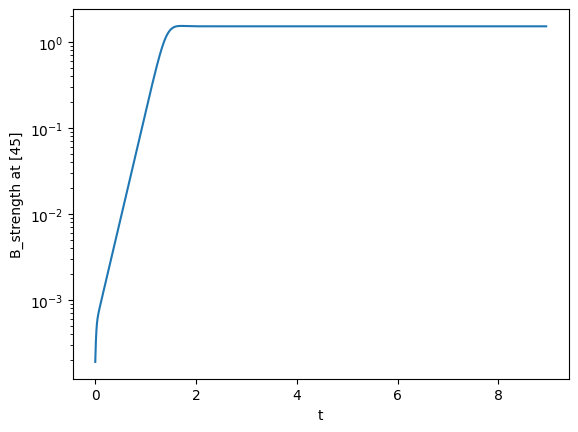

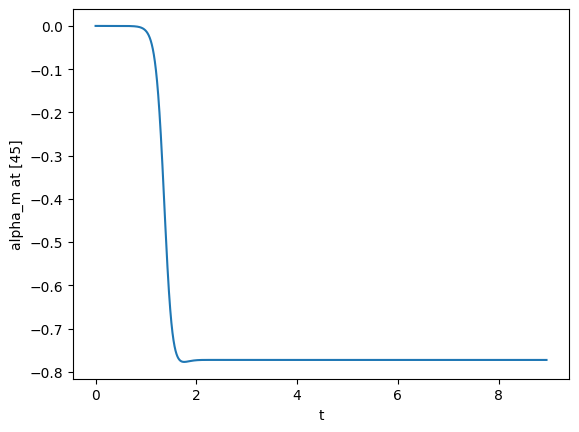

In [18]:

#plot time vs strength
time=np.linspace(0,T,Nt+1)
#make time binto myr using eta_dim and h
time = time*eta_dim/h

space_index = 45
plt.plot(time,B_strength[:,space_index])
plt.xlabel('t')
plt.ylabel(f'B_strength at [{space_index}]')
plt.yscale('log')
plt.show()
plt.plot(time,alpha_m_list[:,space_index])
plt.xlabel('t')
plt.ylabel(f'alpha_m at [{space_index}]')
plt.show()


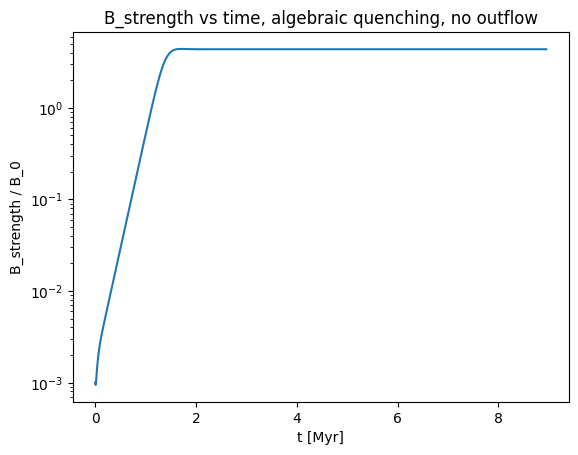

In [19]:

#plot time vs strength
time=np.linspace(0,T,Nt+1)

time = time*eta_dim/h
plt.plot(time,B_strength[:,25])
plt.xlabel('t [Myr]')
plt.title('B_strength vs time, algebraic quenching, no outflow')

plt.ylabel('B_strength / B_0')
plt.yscale('log')
plt.show()